# Problem 1: Importance Sampling

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

In [1]:
#from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas

Index(['Unnamed: 0', 'x', 'y', 'y_err'], dtype='object')


Text(0, 0.5, 'y')

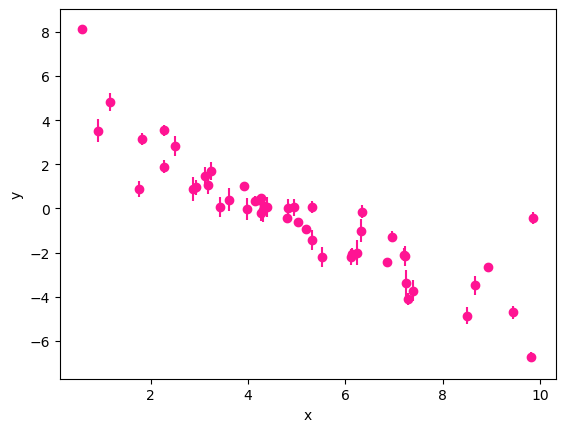

In [2]:
tab = pandas.read_csv('../Day3/line_fitting.csv')
print(tab.columns)

plt.errorbar(tab['x'], tab['y'], yerr=tab['y_err'], fmt='o', c='deeppink')
x_rng = np.arange(0,11)
plt.xlabel('x')
plt.ylabel('y')

Fit a model to the data using:
a. Uniform priors on all parameters
b. Modestly informative Gaussian priors on all parameters
c. Strongly informative Gaussian priors on all parameters

Draw samples from the posterior using any sampler of your choosing.

In [6]:
## fit the data using HMC / NUTS
import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

import corner
import arviz as az

numpyro.set_host_device_count(2)

In [4]:
dist.Normal?

Init signature: dist.Normal(loc=0.0, scale=1.0, *, validate_args=None)
Docstring:     
Base class for probability distributions in NumPyro. The design largely
follows from :mod:`torch.distributions`.

:param batch_shape: The batch shape for the distribution. This designates
    independent (possibly non-identical) dimensions of a sample from the
    distribution. This is fixed for a distribution instance and is inferred
    from the shape of the distribution parameters.
:param event_shape: The event shape for the distribution. This designates
    the dependent dimensions of a sample from the distribution. These are
    collapsed when we evaluate the log probability density of a batch of
    samples using `.log_prob`.
:param validate_args: Whether to enable validation of distribution
    parameters and arguments to `.log_prob` method.

As an example:

.. doctest::

   >>> import jax.numpy as jnp
   >>> import numpyro.distributions as dist
   >>> d = dist.Dirichlet(jnp.ones((2, 3, 4)))
 

In [83]:
def linear_model_uniform(x, yerr, y=None):
    m = numpyro.sample("m", dist.Uniform(-10, 0))
    b = numpyro.sample("b", dist.Uniform(1, 15))

    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(m * x + b, yerr), obs=y)

def linear_model_gaussian_modest(x, yerr, y=None):
    m = numpyro.sample("m", dist.Normal(-1, 5))
    b = numpyro.sample("b", dist.Normal(5, 5))

    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(m * x + b, yerr), obs=y)

def linear_model_gaussian_strong(x, yerr, y=None):
    m = numpyro.sample("m", dist.Normal(-1.1, 0.3))
    b = numpyro.sample("b", dist.Normal(5.4, 0.3))

    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(m * x + b, yerr), obs=y)

In [84]:
# uniform prior sampling
sampler_uniform = infer.MCMC(
    infer.NUTS(linear_model_uniform),
    num_warmup=2000,
    num_samples=4000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_uniform.run(jax.random.PRNGKey(0), tab['x'].values, tab['y_err'].values, y=tab['y'].values)

# modest gaussian sampling
sampler_gauss_modest = infer.MCMC(
    infer.NUTS(linear_model_gaussian_modest),
    num_warmup=2000,
    num_samples=4000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_gauss_modest.run(jax.random.PRNGKey(0), tab['x'].values, tab['y_err'].values, y=tab['y'].values)

# strong gaussian sampling
sampler_gauss_strong = infer.MCMC(
    infer.NUTS(linear_model_gaussian_strong),
    num_warmup=2000,
    num_samples=4000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_gauss_strong.run(jax.random.PRNGKey(0), tab['x'].values, tab['y_err'].values, y=tab['y'].values)

Running chain 0:   0%|          | 0/6000 [00:02<?, ?it/s]

CPU times: user 2.74 s, sys: 75 ms, total: 2.81 s
Wall time: 2.8 s


Running chain 1: 100%|██████████| 6000/6000 [00:03<00:00, 1918.26it/s]



CPU times: user 2.54 s, sys: 69.8 ms, total: 2.61 s
Wall time: 2.47 s


Running chain 1: 100%|██████████| 6000/6000 [00:02<00:00, 2020.29it/s]


CPU times: user 2.57 s, sys: 69.3 ms, total: 2.64 s
Wall time: 2.49 s


Running chain 1: 100%|██████████| 6000/6000 [00:02<00:00, 2333.90it/s]


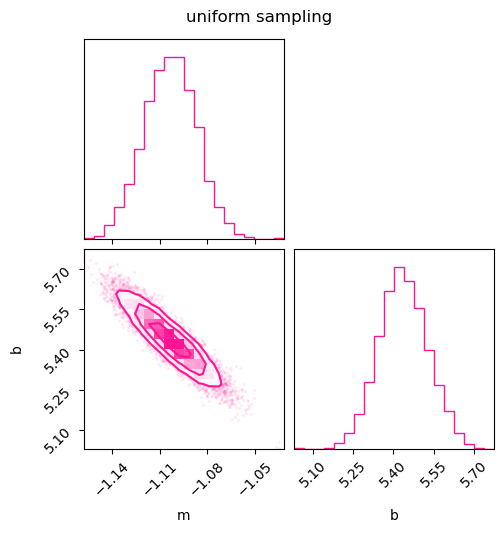

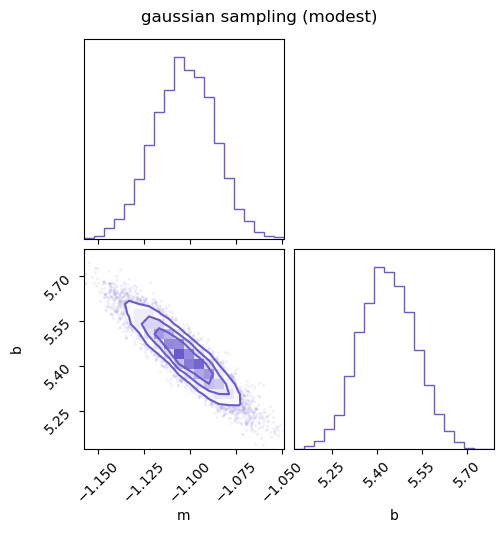

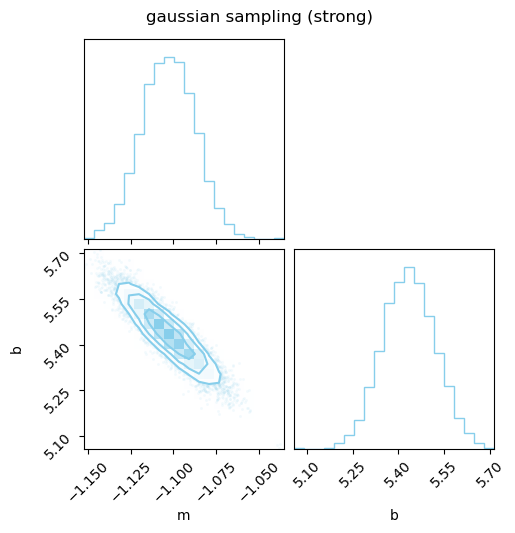

In [85]:
inf_data_uniform = az.from_numpyro(sampler_uniform)
corner.corner(inf_data_uniform, var_names=["m", "b"], color='deeppink');
plt.suptitle('uniform sampling')
plt.show()

inf_data_gauss_modest = az.from_numpyro(sampler_gauss_modest)
corner.corner(inf_data_gauss_modest, var_names=["m", "b"], color='slateblue');
plt.suptitle('gaussian sampling (modest)')
plt.show()

inf_data_gauss_strong = az.from_numpyro(sampler_gauss_strong)
corner.corner(inf_data_gauss_strong, var_names=["m", "b"], color='skyblue');
plt.suptitle('gaussian sampling (strong)')
plt.show()

After sampling in cases (b) and (c), calculate importance weights and resample your posteriors in order to "undo" the informative prior. This step will create a vector of unweighted posterior samples from your original vector of weighted posterior samples. Verify that after importance sampling your results are equivalent to what you obtained in case (a).

Examine the posterior distributions. Do you see any numerical noise or other sampling artifacts introduced by importance sampling?

In [96]:
np.random.choice?

Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

.. versionadded:: 1.7.0

.. note::
    New code should use the `~numpy.random.Generator.choice`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
a : 1-D array-like or int
    If an ndarray, a random sample is generated from its elements.
    If an int, the random sample is generated as if it were ``np.arange(a)``
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
replace : boolean, optional
    Whether the sample is with or without replacement. Default is True,
    meaning that a value of ``a`` can be selected multiple times.
p : 1-D array-like, optional
    The probabilities associated with each entry in a.
    If not given, the sample assumes a unif

In [91]:
prior_sample_m_gmodest = dist.Normal(-1, 5).sample(jax.random.PRNGKey(0), (8000,))
posterior_sample_m_gmodest = sampler_gauss_modest.get_samples()['m']

prior_sample_b_gmodest = dist.Normal(5, 5).sample(jax.random.PRNGKey(0), (8000,))
posterior_sample_b_gmodest = sampler_gauss_modest.get_samples()['b']

prior_sample_m_gstrong = dist.Normal(-1.1, 0.3).sample(jax.random.PRNGKey(0), (8000,))
posterior_sample_m_gstrong = sampler_gauss_strong.get_samples()['m']

prior_sample_b_gstrong = dist.Normal(5.4, 0.3).sample(jax.random.PRNGKey(0), (8000,))
posterior_sample_b_gstrong = sampler_gauss_strong.get_samples()['b']

Text(0.5, 1.0, 'm; modest gaussian')

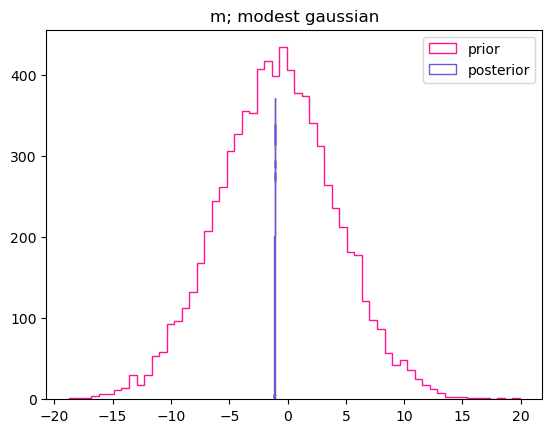

In [92]:
plt.hist(prior_sample_m_gmodest, color='deeppink', bins=60, histtype='step', label='prior')
plt.hist(posterior_sample_m_gmodest, color='slateblue', bins=60, histtype='step', label='posterior')
plt.legend()
plt.title('m; modest gaussian')

Text(0.5, 1.0, 'b; modest gaussian')

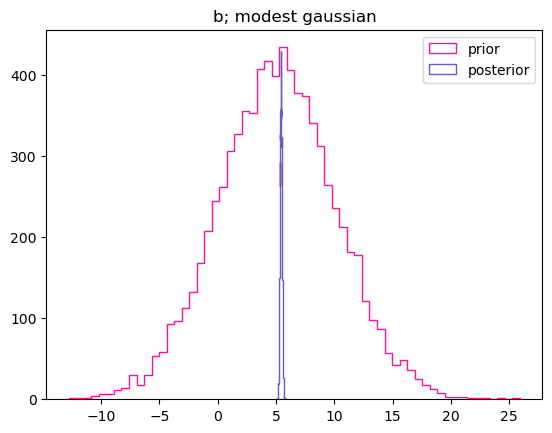

In [93]:
plt.hist(prior_sample_b_gmodest, color='deeppink', bins=60, histtype='step', label='prior')
plt.hist(posterior_sample_b_gmodest, color='slateblue', bins=60, histtype='step', label='posterior')
plt.legend()
plt.title('b; modest gaussian')

Text(0.5, 1.0, 'm; strong gaussian')

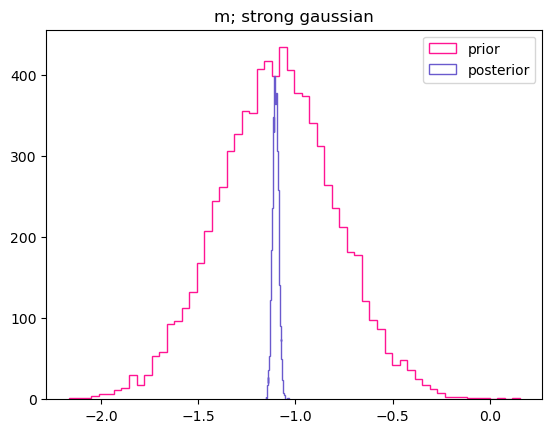

In [94]:
plt.hist(prior_sample_m_gstrong, color='deeppink', bins=60, histtype='step', label='prior')
plt.hist(posterior_sample_m_gstrong, color='slateblue', bins=60, histtype='step', label='posterior')
plt.legend()
plt.title('m; strong gaussian')

Text(0.5, 1.0, 'b; strong gaussian')

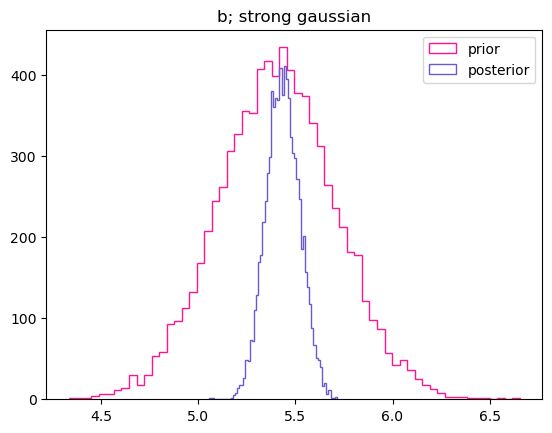

In [95]:
plt.hist(prior_sample_b_gstrong, color='deeppink', bins=60, histtype='step', label='prior')
plt.hist(posterior_sample_b_gstrong, color='slateblue', bins=60, histtype='step', label='posterior')
plt.legend()
plt.title('b; strong gaussian')

# Problem 2: Umbrella Sampling Tutorial

Work through the umbrella sampling tutorial here: https://gjgilbert.github.io/tutorials/umbrella_sampling/

Once you complete the tutorial, return to the Line Fitting dataset from Problem 1. Fit a model using umbrella sampling. You'll need to choose how to define your umbrella windows and biases - there are many possible solutions! After sampling from individual umbrellas, combine your samples into a single set of posterior samples. Verify that the results you obtain from umbrella sampling are equivalent to the results you obtain from other methods.

# Problem 3: Reparameterizing a Model

Read in the Two Component Sinusoid dataset (two_component_sinusoid.csv) and plot the data.

Fit a model using the most "obvious" parameterization:

$y(x) = A_1 \sin(2\pi f_1 x - \phi_1 + A_2 \sin(2\pi f_2 x - \phi_2)$

Place appropriate independent priors on each of the six free parameters. Try fitting a model, drawing samples using a sampler of your choosing. Check for convergence and assess the quality of your results. Re-run your model a few times and check if your results remain consistent from run-to-run.

You will probably not acheive a very good fit using this parameterization. Why is this parameterization problematic? Re-parameterize the model in order to get a more robust fit. Check for convergence and that your posteriors remain consistent from run-to-run.